# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
from __future__ import print_function, division

import os
import numpy as np
import pandas as pd
import copy
import time
import random
import seaborn as sns
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import requests
import PIL.Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
torch.__version__

'1.0.0.dev20181024'

In [3]:
# see https://github.com/pytorch/pytorch/issues/7068
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic=True

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is available!  Training on GPU ...


In [5]:
# These are referred to in many places so set now 
checkpt = ""
state_dicts_name = ""

In [6]:
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
       lr +=[ param_group['lr'] ]
    return lr

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [7]:
data_dir = './flower_data'
train_dir = data_dir + '/train/'
valid_dir = data_dir + '/valid/'
test_dir  = data_dir + '/test/'
testset_dir = data_dir + '/testset/'
testset_subdir = data_dir + '/testset/testdir/'

Image mean and standard deviation used will be the standard Imagenet values unless variables `img_means` and `img_std` are not `None`

In [8]:
# Set these if desired (below) to use calculated means and std
img_means = None
img_std = None

In [9]:
def imshow(image, ax=None, title=None, filename=None, normalize=True):
    """Imshow for Tensor."""
    
    global img_means, img_std
    
    if img_means is not None:
        imgmeans = img_means
    else: 
        imgmeans = [0.485, 0.456, 0.406]

    if img_std is not None:
        imgstd = img_std
    else: 
        imgstd = [0.229, 0.224, 0.225]
        
    if isinstance(image, torch.Tensor): image = copy.deepcopy(image.numpy())
        
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    if isinstance(image, np.ndarray):     # type(image).__module__ == "numpy":    #
        image = image.transpose((1, 2, 0))
    else:
        image = image.numpy.transpose((1, 2, 0))
    
    
    if normalize:
        # Undo preprocessing
        mean = np.array(imgmeans)
        std = np.array(imgstd)
        image = std * image + mean
        # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
        image = np.clip(image, 0, 1)

    if title is not None:
        ax.set_title(title)
    if filename is not None: 
        ax.set_xlabel(filename)
        
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

In [10]:
def unfreeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = True
        unfreeze(child)

In [11]:
def freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        freeze(child)

In [12]:
batch_size = 64  # 16 if unfreezing
num_workers = 4

In [13]:
image_size = 224  # 256

if img_means is not None:
    imgmeans = img_means
else: 
    imgmeans = [0.485, 0.456, 0.406]

if img_std is not None:
    imgstd = img_std
else: 
    imgstd = [0.229, 0.224, 0.225]
        
data_transforms = {
    'train': transforms.Compose([transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(1.0, 1.5), 
                                                         shear=None, resample=PIL.Image.BILINEAR, fillcolor=0),
                                       transforms.Resize(image_size + (image_size//7), interpolation=PIL.Image.BILINEAR),
                                       transforms.CenterCrop(image_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05), 
                                       transforms.ToTensor(),
                                       transforms.Normalize(imgmeans, imgstd)
                                ]), 
    'valid': transforms.Compose([transforms.Resize(image_size + (image_size//7)),
                                       transforms.CenterCrop(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize(imgmeans, imgstd)
                                ]),
    'test' : transforms.Compose([transforms.Resize(image_size + (image_size//7)),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(imgmeans, imgstd)
                                ]),
    'testset' : transforms.Compose([transforms.Resize(image_size + (image_size//7)),
                                      transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(imgmeans, imgstd)
                                ])
}    

In [14]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size,
                                              shuffle=False if x[:4]=='test' else True, 
                                              num_workers=num_workers)
              for x in ['train', 'valid', 'test']}

### Use ImageFolderWithPaths wrapper as alternative datasets and loaders for test and kaggle images
 
Seems to only work with num_workers = 0

In [16]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [17]:
test_datasets = {x: ImageFolderWithPaths(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['valid', 'test', 'testset']}

test_dataloaders = {x: torch.utils.data.DataLoader(test_datasets[x], 
                                              batch_size=batch_size,
                                              shuffle=False)
              for x in ['valid', 'test', 'testset']}

In [18]:
class_counts = defaultdict(int)
for _, c in image_datasets["train"].imgs:
    class_counts[c] += 1

class_weights = [1-(float(class_counts[class_id])/len(image_datasets["train"].imgs))
                 for class_id in range(len(image_datasets["train"].classes))]
class_weights = torch.FloatTensor(class_weights)
class_weights.to(device)

tensor([0.9959, 0.9942, 0.9947, 0.9925, 0.9945, 0.9896, 0.9889, 0.9942, 0.9933,
        0.9942, 0.9945, 0.9908, 0.9901, 0.9942, 0.9925, 0.9930, 0.9948, 0.9928,
        0.9890, 0.9947, 0.9948, 0.9950, 0.9945, 0.9916, 0.9905, 0.9945, 0.9907,
        0.9927, 0.9945, 0.9953, 0.9957, 0.9950, 0.9905, 0.9860, 0.9933, 0.9950,
        0.9933, 0.9918, 0.9852, 0.9925, 0.9847, 0.9889, 0.9950, 0.9760, 0.9907,
        0.9913, 0.9942, 0.9918, 0.9889, 0.9686, 0.9898, 0.9893, 0.9928, 0.9915,
        0.9860, 0.9924, 0.9869, 0.9915, 0.9947, 0.9870, 0.9945, 0.9927, 0.9936,
        0.9936, 0.9866, 0.9922, 0.9945, 0.9934, 0.9930, 0.9950, 0.9922, 0.9902,
        0.9882, 0.9776, 0.9783, 0.9855, 0.9873, 0.9687, 0.9829, 0.9948, 0.9893,
        0.9875, 0.9794, 0.9875, 0.9841, 0.9899, 0.9927, 0.9927, 0.9922, 0.9823,
        0.9766, 0.9937, 0.9899, 0.9910, 0.9919, 0.9948, 0.9799, 0.9846, 0.9890,
        0.9918, 0.9896, 0.9924], device='cuda:0')

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [19]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

class_to_idx = dataloaders['train'].dataset.class_to_idx

idx_to_class =  {y:x for x,y in class_to_idx.items()}

# Data exploration

In [20]:
for flower in sorted(cat_to_name.items(), key=lambda x: int(x[0])):
    print(flower)

('1', 'pink primrose')
('2', 'hard-leaved pocket orchid')
('3', 'canterbury bells')
('4', 'sweet pea')
('5', 'english marigold')
('6', 'tiger lily')
('7', 'moon orchid')
('8', 'bird of paradise')
('9', 'monkshood')
('10', 'globe thistle')
('11', 'snapdragon')
('12', "colt's foot")
('13', 'king protea')
('14', 'spear thistle')
('15', 'yellow iris')
('16', 'globe-flower')
('17', 'purple coneflower')
('18', 'peruvian lily')
('19', 'balloon flower')
('20', 'giant white arum lily')
('21', 'fire lily')
('22', 'pincushion flower')
('23', 'fritillary')
('24', 'red ginger')
('25', 'grape hyacinth')
('26', 'corn poppy')
('27', 'prince of wales feathers')
('28', 'stemless gentian')
('29', 'artichoke')
('30', 'sweet william')
('31', 'carnation')
('32', 'garden phlox')
('33', 'love in the mist')
('34', 'mexican aster')
('35', 'alpine sea holly')
('36', 'ruby-lipped cattleya')
('37', 'cape flower')
('38', 'great masterwort')
('39', 'siam tulip')
('40', 'lenten rose')
('41', 'barbeton daisy')
('42', 

In [21]:
print("Training data files per class:")
print("-----------------------------------")
for i in range (1, 103):
    x=len(os.listdir(train_dir+str(i))) 
    print('{:<3} {:<25} {:>5}'. format(i, cat_to_name[str(i)], x))

Training data files per class:
-----------------------------------
1   pink primrose                27
2   hard-leaved pocket orchid    49
3   canterbury bells             36
4   sweet pea                    44
5   english marigold             54
6   tiger lily                   35
7   moon orchid                  33
8   bird of paradise             70
9   monkshood                    41
10  globe thistle                38
11  snapdragon                   68
12  colt's foot                  73
13  king protea                  38
14  spear thistle                44
15  yellow iris                  38
16  globe-flower                 36
17  purple coneflower            60
18  peruvian lily                65
19  balloon flower               38
20  giant white arum lily        46
21  fire lily                    34
22  pincushion flower            47
23  fritillary                   72
24  red ginger                   35
25  grape hyacinth               34
26  corn poppy                   

In [22]:
print("Validation data files per class:")
print("-----------------------------------")
for i in range (1, 103):
    x=len(os.listdir(valid_dir+str(i))) 
    print('{:<3} {:<25} {:>5}'. format(i, cat_to_name[str(i)], x))

Validation data files per class:
-----------------------------------
1   pink primrose                 8
2   hard-leaved pocket orchid     6
3   canterbury bells              2
4   sweet pea                     6
5   english marigold              7
6   tiger lily                    1
7   moon orchid                   1
8   bird of paradise              5
9   monkshood                     3
10  globe thistle                 4
11  snapdragon                   10
12  colt's foot                   5
13  king protea                   5
14  spear thistle                 1
15  yellow iris                   7
16  globe-flower                  2
17  purple coneflower            16
18  peruvian lily                11
19  balloon flower                4
20  giant white arum lily         7
21  fire lily                     4
22  pincushion flower             8
23  fritillary                   12
24  red ginger                    5
25  grape hyacinth                2
26  corn poppy                 

In [23]:
print("Testing data files per class:")
print("-----------------------------------")
for i in range (1, 103):
    x=len(os.listdir(test_dir+str(i))) 
    print('{:<3} {:<25} {:>5}'. format(i, cat_to_name[str(i)], x))

Testing data files per class:
-----------------------------------
1   pink primrose                 5
2   hard-leaved pocket orchid     5
3   canterbury bells              2
4   sweet pea                     6
5   english marigold              4
6   tiger lily                    9
7   moon orchid                   6
8   bird of paradise             10
9   monkshood                     2
10  globe thistle                 3
11  snapdragon                    9
12  colt's foot                   9
13  king protea                   6
14  spear thistle                 3
15  yellow iris                   4
16  globe-flower                  3
17  purple coneflower             9
18  peruvian lily                 6
19  balloon flower                7
20  giant white arum lily         3
21  fire lily                     2
22  pincushion flower             4
23  fritillary                    7
24  red ginger                    2
25  grape hyacinth                5
26  corn poppy                    

In [24]:
images, labels = next(iter(dataloaders['train']))

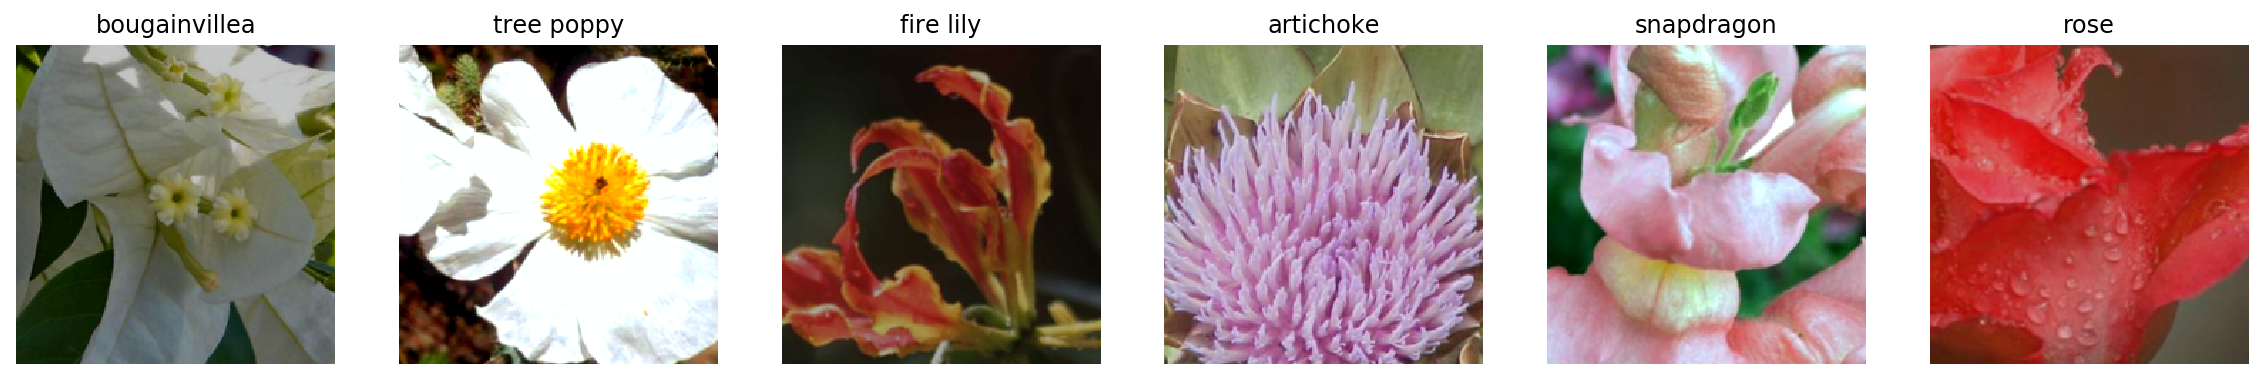

In [25]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    title = cat_to_name[idx_to_class[labels[ii].item()]]
    imshow(images[ii], ax=ax, title=title, filename=None, normalize=True)

In [26]:
images, labels = next(iter(dataloaders['valid']))

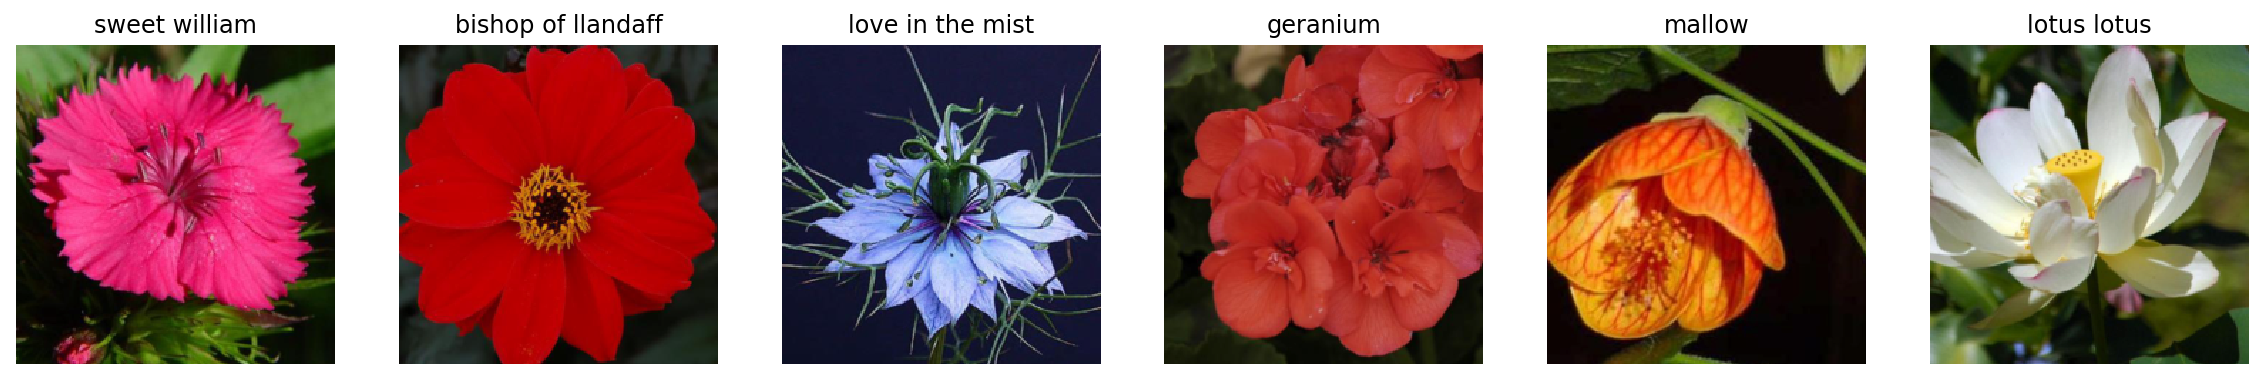

In [27]:
fig, axes = plt.subplots(figsize=(20,6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    title = cat_to_name[idx_to_class[labels[ii].item()]]
    imshow(images[ii], ax=ax, title=title, filename=None, normalize=True)

In [28]:
images, labels = next(iter(dataloaders['test']))

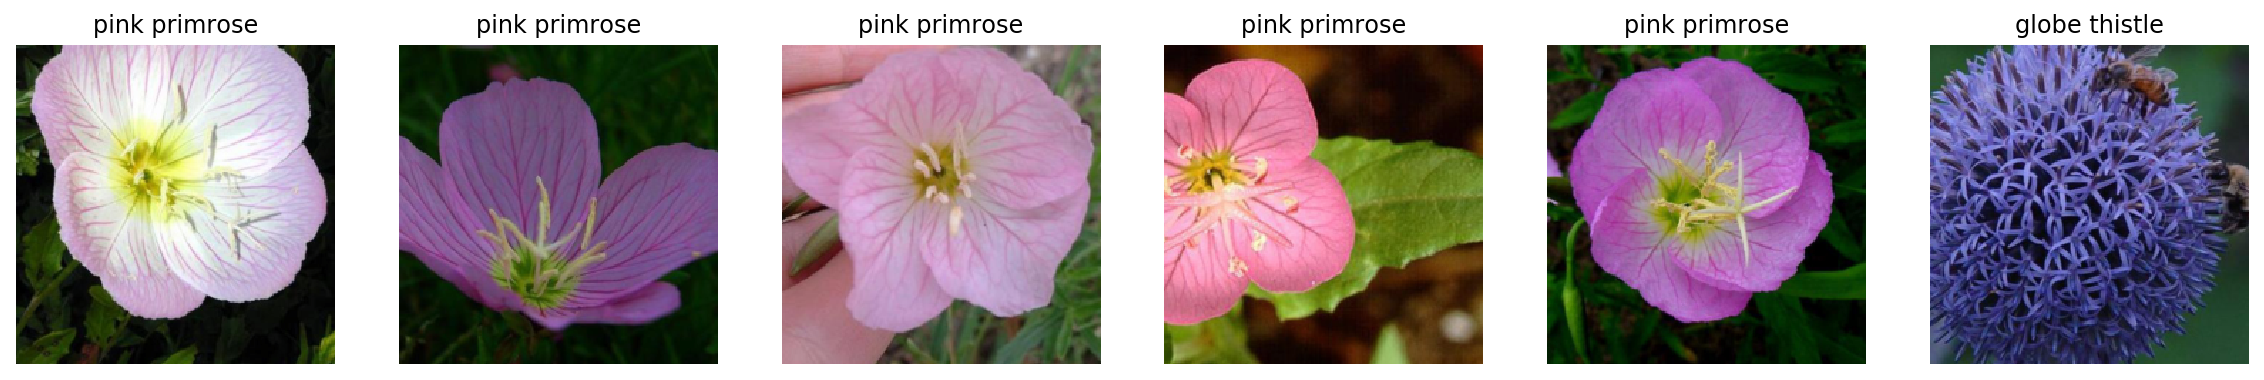

In [29]:
fig, axes = plt.subplots(figsize=(20,6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    title = cat_to_name[idx_to_class[labels[ii].item()]]
    imshow(images[ii], ax=ax, title=title, filename=None, normalize=True)

### Kaggle test set is not organised with labels folders, need to match image file name and class prediction

In [30]:
images, labels, paths = next(iter(test_dataloaders['testset']))

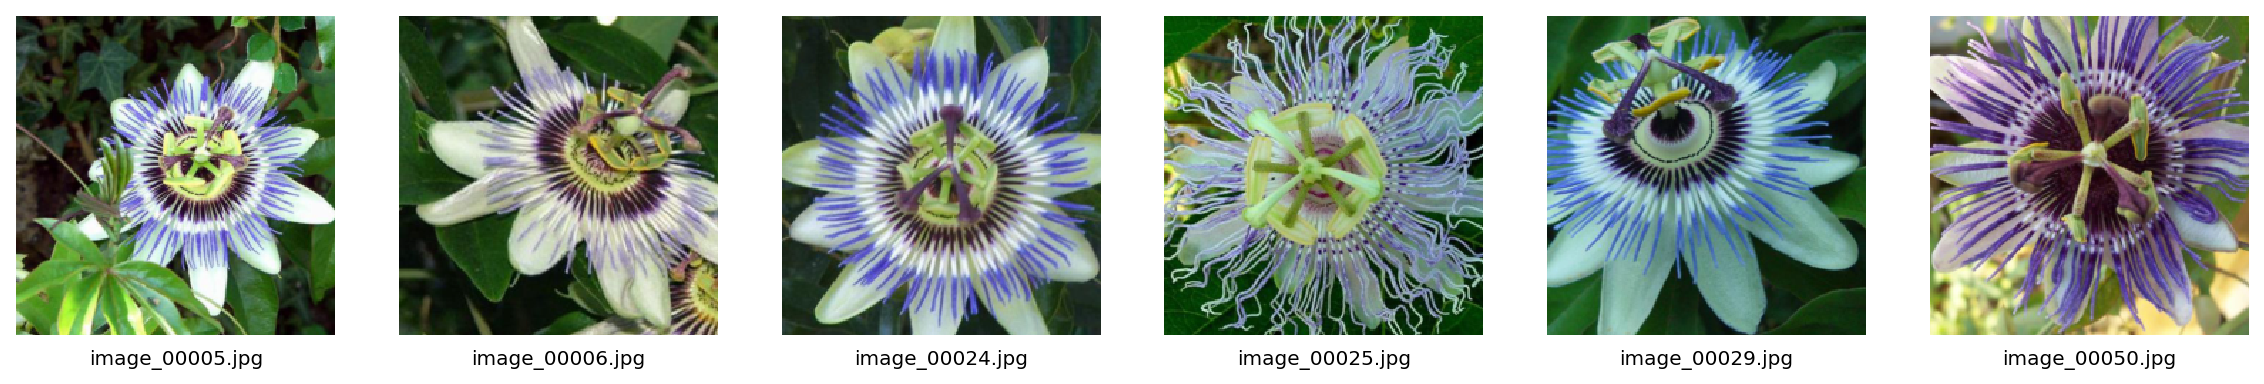

In [31]:
fig, axes = plt.subplots(figsize=(20,6), ncols=6)

for ii in range(6):
    ax = axes[ii]
    filename = os.path.basename(paths[ii])
    imshow(images[ii], ax=ax, title=None, filename=filename, normalize=True)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

## Model definition, swap last 2 layers with fastai approach 

In [32]:
# From fastai...
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

In [33]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

In [34]:
def get_resnet_model(modelname='resnet50', swap=False, sm=False):
    if modelname == 'resnet18':
        model = models.resnet18(pretrained=True)   
    elif modelname == 'resnet34':    
        model = models.resnet34(pretrained=True)   
    elif modelname == 'resnet50':    
        model = models.resnet50(pretrained=True)
    elif modelname == 'resnet101':    
        model = models.resnet101(pretrained=True)
    elif modelname == 'resnet152':    
        model = models.resnet152(pretrained=True)
    else:
        model = models.resnet50(pretrained=True)
        
    for param in model.parameters():
        param.requires_grad = False    
        
    clf_input_size = model.fc.in_features
    clf_output_size = 102 # len(class_names)
    nf = clf_input_size * 2 # For flattening ...
    
    if swap==True:
        # swapping last 2 layers for new ones - adaptive max pooling and more layers
        # per the fastai resnet implementation...
        Resnetlayers = []
        Resnetlayers.append(AdaptiveConcatPool2d())
        Resnetlayers.append(Flatten())
        Resnetlayers.append(nn.BatchNorm1d(nf, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        Resnetlayers.append(nn.Dropout(p=0.25))
        Resnetlayers.append(nn.Linear(in_features=nf, out_features=512, bias=True))
        Resnetlayers.append(nn.ReLU())
        Resnetlayers.append(nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        Resnetlayers.append(nn.Dropout(p=0.25))
        Resnetlayers.append(nn.Linear(in_features=512, out_features=clf_output_size, bias=True))        
        if sm==True:
            Resnetlayers.append(nn.LogSoftmax())
            
        Resnetlist = list(model.children())[:-2] + Resnetlayers
        model = torch.nn.Sequential(*Resnetlist)
    else:    
        # standard replacing the fc layer to suit the number of classes
        classifier = nn.Linear(clf_input_size, clf_output_size)
        model.fc = classifier

    model.class_to_idx = class_to_idx
    
    return model

In [35]:
del model

In [36]:
model_name = "resnet152"

In [37]:
model = get_resnet_model(model_name, swap=True, sm=False)
model = model.to(device)

In [38]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

## Criterion, 2 versions - with and without weights...

In [39]:
# Passing in class_weights previously determined (first phase)
use_weights = True
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='sum')  

In [40]:
# OR, not using weights (subsequent phases)...
use_weights = False
criterion = nn.CrossEntropyLoss()

In [41]:
use_weights

True

## Optimizer

In [42]:
learning_rate=0.001

In [43]:
# Set training parameters
parameters = filter(lambda p: p.requires_grad, model.parameters())

optimizer = optim.Adam(parameters, lr=learning_rate)

## Scheduler

In [44]:
multistep = False
OnPlateau = False

# Decay LR by a factor of 0.1 every 14 epochs (9 for inception)
if OnPlateau == True:
    #exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=0.000001)
    exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
elif multistep==True:
    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, [7, 13, 23], gamma=0.05) # gamma=0.1
else:
    # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 10, gamma=0.1)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 7, gamma=0.05)
    # exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 5, gamma=0.1)

In [45]:
get_learning_rate(optimizer)

[0.001]

## See Appendix for Learning Rate finder

# Training loop

### Only reset starting variables if setting up or starting a new training...

In [44]:
train_losses, valid_losses, val_acc_history, lr_hist = [], [], [], []
best_acc, best_epoch, epoch_loss_min = 0.0, 0, np.Inf

In [45]:
# train_losses, valid_losses, val_acc_history, lr_hist = [], [], [], []
# best_acc, best_epoch, epoch_loss_min = 0.0, 0, np.Inf

def train_model(model, criterion, optimizer, scheduler, use_scheduler=False, use_weights=False, 
                num_epochs=25, first_epoch=0, ufilename=None, is_inception=False):
    
# Define these outside the program so that training can continue from the previous point
#     train_losses, valid_losses = [], []
#     val_acc_history = []
#     best_acc = 0.0
#     best_epoch = 0
#     epoch_loss_min = np.Inf   # track change in validation loss

    global train_losses, valid_losses, val_acc_history, lr_hist
    global best_acc, best_epoch, epoch_loss_min
    global model_name
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_optim_wts = copy.deepcopy(optimizer.state_dict())

    curr_lr = get_learning_rate(optimizer)
    
    # if first_epoch is used assume its to restart training at that point using 1-based indexing
    # so decrement by 1 then add the value to num_epochs
    if first_epoch > 0:
        first_epoch -= 1
        num_epochs = first_epoch + num_epochs
    
    for epoch in range(first_epoch, num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 11)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                if use_scheduler==True: 
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        # using best accuracy - the max setting
                        scheduler.step(best_acc)
                    else:    
                        scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    
                    outputs = model(inputs)
                    
                    if isinstance(outputs, tuple):
                        if epoch == first_epoch:
                            print("Outputs:", outputs)
                        
                        if is_inception and phase == 'train':
                            loss1 = criterion(outputs[0], labels)
                            loss2 = criterion(outputs[1], labels)
                            loss = loss1 + 0.4*loss2
                        else:    
                            loss = sum((criterion(o,labels) for o in outputs))
                    else:
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * (1 if use_weights==True else inputs.size(0))
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                curr_lr = get_learning_rate(optimizer)
                lr_hist.append(curr_lr)
                
                print("Learning rate: {}".format(curr_lr))
                
            if phase == 'valid':
                valid_losses.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                filename = model_name + '_acc_'
                if ufilename is not None:
                    filename = filename + ufilename + '_'
                else:    
                    if use_scheduler==True:
                        filename = filename + 'schd_'
                    if use_weights==True:
                        filename = filename + 'wgts_'
                filename = filename + str(epoch+1) 
                
                print('Accuracy has increased ({:.6f} --> {:.6f}).  Saving model as {}...'.format(
                    best_acc, epoch_acc,
                    filename))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_optim_wts = copy.deepcopy(optimizer.state_dict())
                torch.save(best_model_wts, filename + '.pt')
                torch.save(best_optim_wts, filename + '_optimizer.pt')               
                
            if phase == 'valid' and epoch_loss <= epoch_loss_min:
                filename = model_name + '_'
                if ufilename is not None:
                    filename = filename + ufilename + '_'
                else:    
                    if use_scheduler==True:
                        filename = filename + 'schd_'
                    if use_weights==True:
                        filename = filename + 'wgts_'
                filename = filename + str(epoch+1) 
                
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model as {}...'.format(
                epoch_loss_min,
                epoch_loss,
                filename))
                
                best_epoch = epoch+1
                
                torch.save(model.state_dict(), filename + '.pt')
                torch.save(optimizer.state_dict(), filename + '_optimizer.pt')
                epoch_loss_min = epoch_loss

        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation Accuracy: {:4f}'.format(best_acc))
    print('Best validation Loss    : {:4f}'.format(epoch_loss_min))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    optimizer.load_state_dict(best_optim_wts)
    
    return model

# Train the model...

### Define tracking variables outside the program so that training can continue from the previous point

**Only run these if starting from scratch, otherwise preserve them**

Remove unwanted array elements if resetting back to an earlier epoch rather than starting again after the last one...

In [47]:
train_losses, valid_losses, val_acc_history, lr_hist = [], [], [], []

In [48]:
best_acc, best_epoch, epoch_loss_min = 0.0, 0, np.Inf

In [49]:
print(best_acc, best_epoch, epoch_loss_min)

0.0 0 inf


In [50]:
use_weights

True

In [51]:
model = train_model(model, 
                    criterion, 
                    optimizer,
                    exp_lr_scheduler, 
                    use_scheduler=True, 
                    use_weights=use_weights, 
                    num_epochs=30,
                    first_epoch=0,
                    ufilename="One",
                    is_inception=(model_name=="inception"))

Epoch 1/30
-----------
Learning rate: [0.001]
train Loss: 1.9241 Acc: 0.6633
valid Loss: 0.6246 Acc: 0.9046
Accuracy has increased (0.000000 --> 0.904645).  Saving model as resnet152_acc_One_1...
Validation loss decreased (inf --> 0.624561).  Saving model as resnet152_One_1...

Epoch 2/30
-----------
Learning rate: [0.001]
train Loss: 0.5659 Acc: 0.8999
valid Loss: 0.3207 Acc: 0.9450
Accuracy has increased (0.904645 --> 0.944988).  Saving model as resnet152_acc_One_2...
Validation loss decreased (0.624561 --> 0.320678).  Saving model as resnet152_One_2...

Epoch 3/30
-----------
Learning rate: [0.001]
train Loss: 0.3537 Acc: 0.9274
valid Loss: 0.2592 Acc: 0.9499
Accuracy has increased (0.944988 --> 0.949878).  Saving model as resnet152_acc_One_3...
Validation loss decreased (0.320678 --> 0.259174).  Saving model as resnet152_One_3...

Epoch 4/30
-----------
Learning rate: [0.001]
train Loss: 0.2599 Acc: 0.9423
valid Loss: 0.2229 Acc: 0.9474
Validation loss decreased (0.259174 --> 0.222

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [52]:
def compare_dicts(dict_1, dict_2):
    dicts_differ = 0
    for key_item_1, key_item_2 in zip(dict_1.items(), dict_2.items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            dicts_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
                
    if dicts_differ == 0:
        print('State_Dicts match')

In [53]:
state_dict = torch.load('resnet152_acc_One_24.pt')
opt_state_dict = torch.load('resnet152_acc_One_24_optimizer.pt')

In [54]:
compare_dicts(model.state_dict(), state_dict)

State_Dicts match


In [55]:
checkpt = 'resnet152_acc_One_24_model_and_opt.pth'

In [56]:
best_epoch

21

In [57]:
best_epoch = 24

In [58]:
best_epoch

24

In [59]:
torch.save({'model_statedict':model.state_dict(),
            'optimizer_statedict':optimizer.state_dict(), 
            'class_to_idx' : model.class_to_idx,
            'best_epoch'   : best_epoch,
            'train_losses' : train_losses, 
            'valid_losses' : valid_losses, 
            'val_acc_history' : val_acc_history, 
            'lr_hist'      : lr_hist}, 
           checkpt)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

### Use for ad-hoc loading... Otherwise run appropriate reload function above

In [60]:
state_dicts_name = 'resnet152_acc_One_24_model_and_opt.pth'

In [61]:
if train_on_gpu:
    state_dicts = torch.load(state_dicts_name)
else:
    state_dicts = torch.load(state_dicts_name, map_location='cpu')

In [62]:
state_dicts.keys()

dict_keys(['model_statedict', 'optimizer_statedict', 'class_to_idx', 'best_epoch', 'train_losses', 'valid_losses', 'val_acc_history', 'lr_hist'])

In [ ]:
model.load_state_dict(state_dicts['model_statedict'])

In [ ]:
optimizer.load_state_dict(state_dicts['optimizer_statedict'])

In [ ]:
model.class_to_idx = state_dicts['class_to_idx']

In [65]:
best_epoch, len(train_losses), len(valid_losses), len(val_acc_history), len(lr_hist)

(24, 30, 30, 30, 30)

In [64]:
train_losses_bak = copy.deepcopy(train_losses)
valid_losses_bak = copy.deepcopy(valid_losses)
val_acc_history_bak = copy.deepcopy(val_acc_history)
lr_hist_bak = copy.deepcopy(lr_hist)

In [66]:
train_losses = train_losses[:best_epoch]
valid_losses = valid_losses[:best_epoch]
val_acc_history = val_acc_history[:best_epoch]
lr_hist = lr_hist [:best_epoch]

In [67]:
best_epoch, len(train_losses), len(valid_losses), len(val_acc_history), len(lr_hist)

(24, 24, 24, 24, 24)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [54]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [55]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [56]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [57]:
# TODO: Display an image along with the top 5 classes

# Appendix

## Learning Rate finder

In [46]:
import math

def find_lr(model, optimizer, init_value = 1e-8, final_value=10., beta = 0.98):
    num = len(dataloaders['train'])-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    
    for images, labels in dataloaders['train']:
        batch_num += 1
        
        #Get the loss for this mini-batch of images/outputs
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model.forward(images)
        
        loss = criterion(output, labels)
        
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        #Do the SGD step
        loss.backward()
        optimizer.step()
        
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    
    return log_lrs, losses

In [47]:
model.to(device);

In [48]:
logs, losses = find_lr(model, optimizer)

In [49]:
plt.rcParams['figure.figsize'] = [9.5, 6]

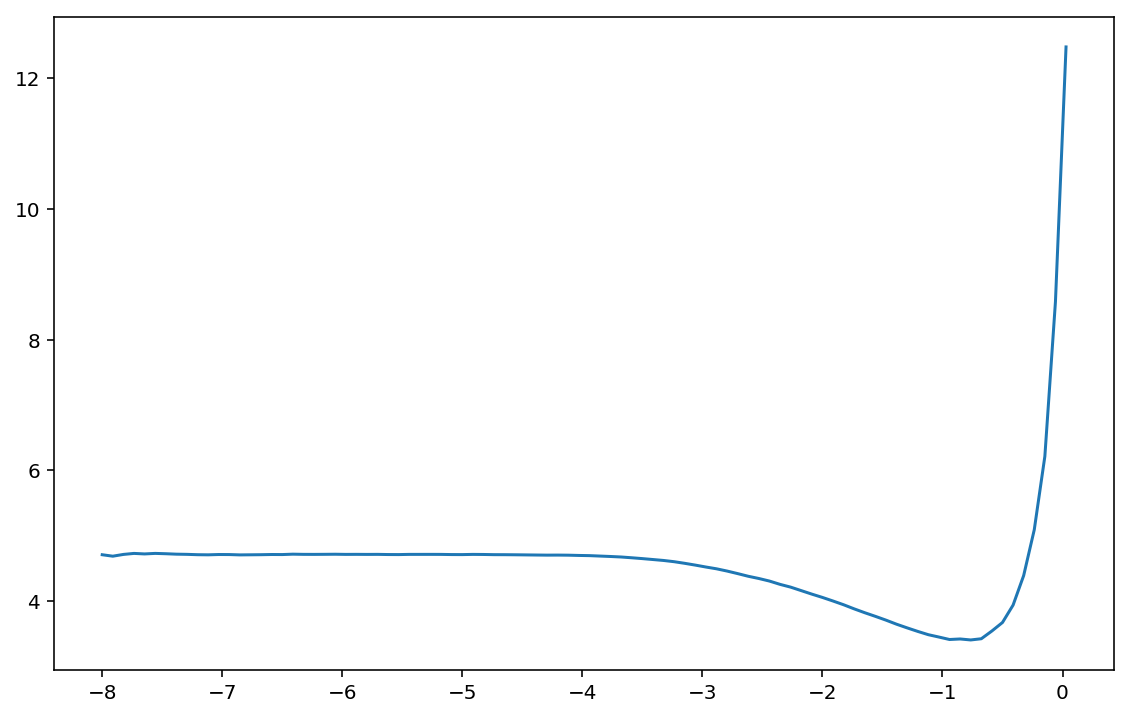

In [50]:
plt.plot(logs,losses)

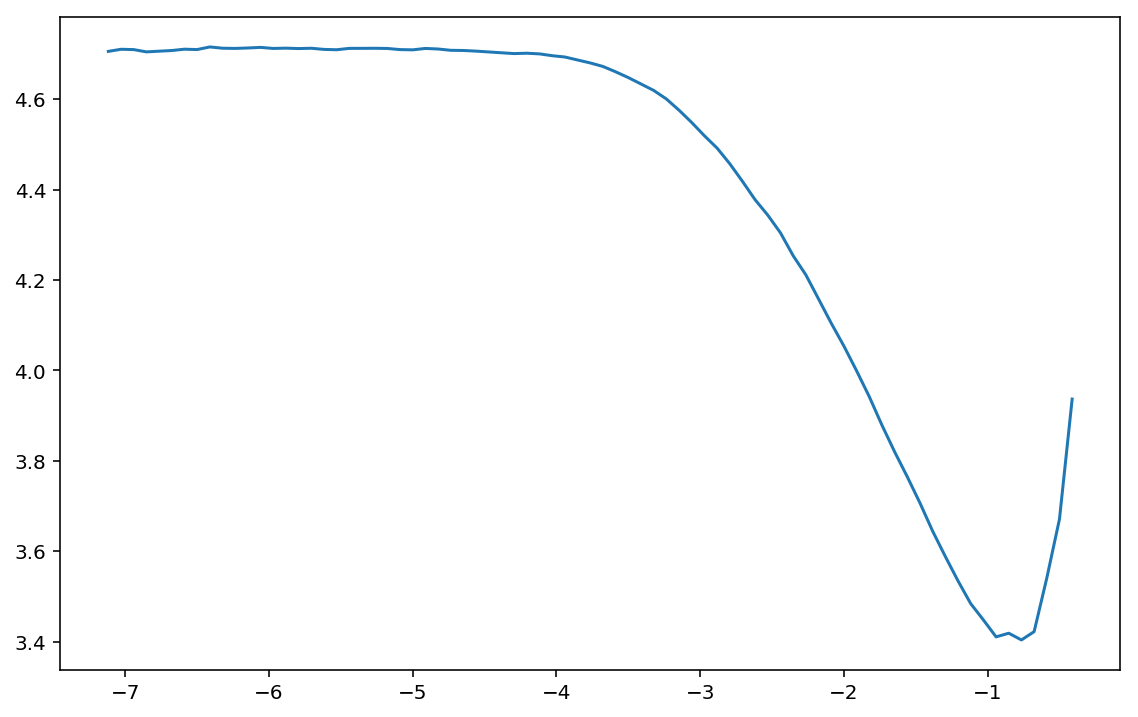

In [51]:
plt.plot(logs[10:-5],losses[10:-5])

## Actual mean and standard deviations

In [58]:
image_size = 224
tfms_basic = transforms.Compose([
        transforms.Resize(image_size + (image_size//7)),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()
])

dataset1 = datasets.ImageFolder(train_dir, transform=tfms_basic)
dataloader1 = torch.utils.data.DataLoader(dataset1, batch_size=128)
dataset2 = datasets.ImageFolder(valid_dir, transform=tfms_basic)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=128)

In [59]:
# Get the mean and standard deviation of all images in train and valid datasets
red_chan = []
gre_chan = []
blu_chan = []

for images, labels in dataloader1:
    for image in images:
        red_chan.append(image[0])
        gre_chan.append(image[1])
        blu_chan.append(image[2])
        
for images, labels in dataloader2:
    for image in images:
        red_chan.append(image[0])
        gre_chan.append(image[1])
        blu_chan.append(image[2])    
        
red_channels = torch.cat(red_chan, dim=0)
green_channels = torch.cat(gre_chan, dim=0)
blue_channels = torch.cat(blu_chan, dim=0) 

In [60]:
img_means = round(red_channels.mean().item(), 4), round(green_channels.mean().item(), 4), round(blue_channels.mean().item(), 4)

In [61]:
img_means = list(img_means)

In [62]:
img_std = round(red_channels.std().item(), 4), round(green_channels.std().item(), 4), round(blue_channels.std().item(), 4)

In [63]:
img_std = list(img_std)

In [64]:
print(img_means)
print(img_std)

[0.5178, 0.411, 0.3295]
[0.2972, 0.2494, 0.2856]


In [65]:
del dataloader1
del dataloader2
del red_chan, gre_chan, blu_chan
del red_channels, green_channels, blue_channels

## Renumber notebook

In [66]:
%%javascript

// Sourced from http://nbviewer.jupyter.org/gist/minrk/5d0946d39d511d9e0b5a

$("#renumber-button").parent().remove();

function renumber() {
    // renumber cells in order
    var i=1;
    IPython.notebook.get_cells().map(function (cell) {
        if (cell.cell_type == 'code') {
            // set the input prompt
            cell.set_input_prompt(i);
            // set the output prompt (in two places)
            cell.output_area.outputs.map(function (output) {
                if (output.output_type == 'execute_result') {
                    output.execution_count = i;
                    cell.element.find(".output_prompt").text('Out[' + i + ']:');
                }
            });
            i += 1;
        }
    });
}

IPython.toolbar.add_buttons_group([{
  'label'   : 'Renumber',
  'icon'    : 'fa-list-ol',
  'callback': renumber,
  'id'      : 'renumber-button'
}]);

<IPython.core.display.Javascript object>